# HPP with multiple energy markets

## Evaluating the performance of a hybrid power plant using HyDesign

HyDesign is an open-source tool for design and optimization of utility scale wind-solar-storage based hybrid power plants.

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Turbine design:**

1. Clearance [m] (`clearance`): Height from the ground to rotor tip at lowest posstion. This parameter controls the wind turbine hub height given a rotor radius: `clearance =  HH - R`. 
2. Specific power of the wind turbine [MW/m2] (`sp`): Defined as `sp = p_rated / ( pi * R^2 )`, it controls the turbine rotor size for a given rated power. Turbines with lower specific power produce more power at lower wind speeds, but are more expensive.
3. Rated power of the wind turbine [MW] (`p_rated`)

**Wind Plant design:**

4. Number of wind turbines in the wind plant [-] (`Nwt`)
5. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

6. Solar plant power capacity [MW] (`solar_MW`)
7. Surface tilt [deg] (`surface_tilt`)
8. Surface azimuth [deg] (`surface_azimuth`)
9. DC-AC ratio [-] (`solar_DCAC`): This parameter controls how much over-planting of PV (in DC power) is connected to the inverters. It is common practice in PV design to have `solar_DCAC = 1.5`. 

**Battery Storage design:**

10. Battery power [MW] (`b_P`)
11. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
12. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.


##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [1]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly_BM import hpp_model
from hydesign.examples import examples_filepath

C:\Users\mikf\Anaconda3\envs\hd2\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [2]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,Unnamed: 11,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN,NaN


In [3]:
name = 'Denmark_good_wind_BM'
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]
input_HA_ts_fn = examples_filepath+ex_site['input_HA_ts_fn'].values[0]
price_up_ts_fn = examples_filepath+ex_site['price_up_ts'].values[0]
price_dwn_ts_fn = examples_filepath+ex_site['price_dwn_ts'].values[0]
price_col = ex_site['price_col'].values[0]


In [4]:
weather_HA = pd.read_csv(input_HA_ts_fn, index_col=0, parse_dates=True)
SO_imbalance = weather_HA['SO_power_imbalance']
print(input_HA_ts_fn)

c:/sandbox/repo/topfarm/hydesign/hydesign/examples/Europe/GWA2_HA/input_ts_Denmark_good_wind_HA.csv


## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [5]:
hpp = hpp_model(
        latitude,
        longitude,
        altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        input_HA_ts_fn = input_HA_ts_fn,
        price_up_ts_fn = price_up_ts_fn,
        price_dwn_ts_fn = price_dwn_ts_fn,
        price_col = price_col,
)


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [6]:
start = time.time()

clearance = 10
sp = 350
p_rated = 5
Nwt = 70
wind_MW_per_km2 = 7
solar_MW = 0
surface_tilt = 50
surface_azimuth = 180
solar_DCAC = 1.5
b_P = 100
b_E_h  = 3
cost_of_batt_degr = 10

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
b_P, b_E_h , cost_of_batt_degr]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )

C:\Users\mikf\Anaconda3\envs\hd2\lib\site-packages\xarray\core\concat.py:532: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
C:\Users\mikf\Anaconda3\envs\hd2\lib\site-packages\xarray\core\concat.py:532: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Evaluation 1 done

Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 350.000
p_rated [MW]: 5.000
Nwt: 70.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 0.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 100.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: 2.848
NPV [MEuro]: 1009.000
IRR: 0.212
revenues [MEuro]: 68.856
LCOE [Euro/MWh]: 57.326
CAPEX [MEuro]: 354.270
OPEX [MEuro]: 5.365
Wind CAPEX [MEuro]: 267.506
Wind OPEX [MEuro]: 5.365
PV CAPEX [MEuro]: 0.000
PV OPEX [MEuro]: 0.000
Batt CAPEX [MEuro]: 20.782
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 65.982
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 554.894
GUF: 0.211
grid [MW]: 300.000
wind [MW]: 350.000
solar [MW]: 0.000
Battery Energy [MWh]: 300.000
Battery Power [MW]: 100.000
Total curtailment [GWh]: 4788.088
Awpp [km2]: 50.000
Apvp [km2]: 0.000
Plant area [km2]: 50.000
Rotor diam [m]: 134.867
Hub height [m]

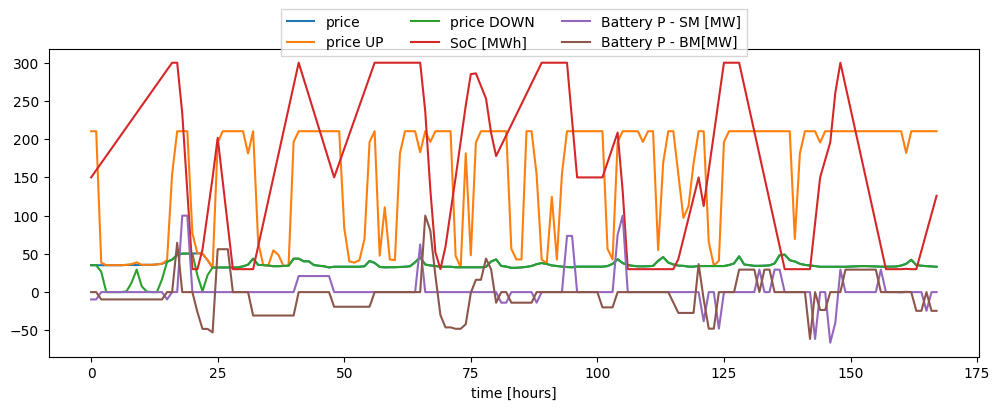

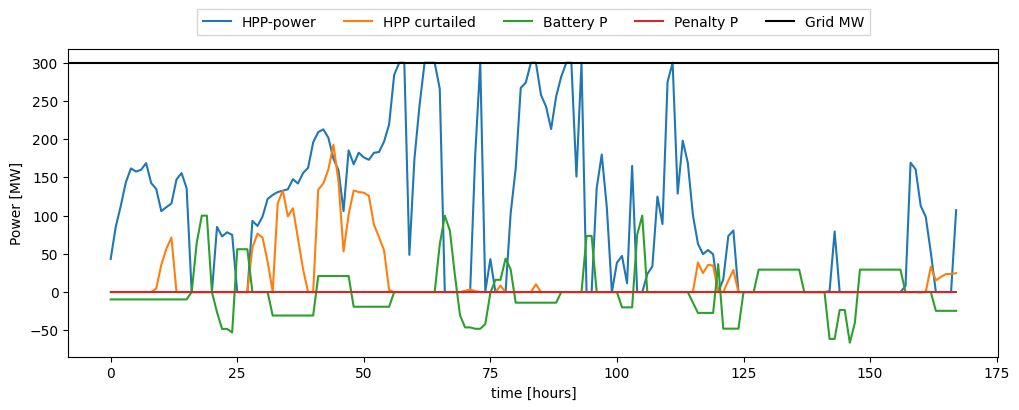

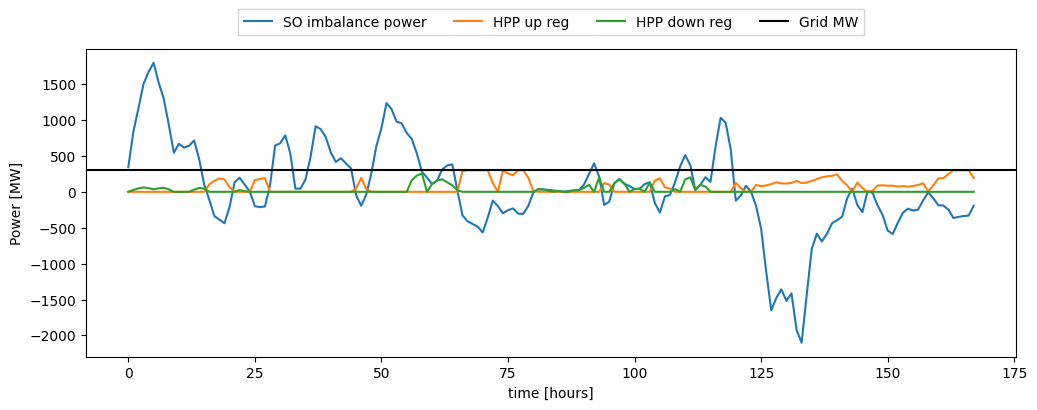

In [7]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
b_BM_t = hpp.prob.get_val('ems.b_BM_t')
price_t = hpp.prob.get_val('ems.price_t')
price_up_reg_t = hpp.prob.get_val('ems.price_up_reg_t')
price_dwn_reg_t = hpp.prob.get_val('ems.price_dwn_reg_t')
b_P_total = b_t + b_BM_t

wind_t = hpp.prob.get_val('ems.wind_t')
wind_BM_t_ext = hpp.prob.get_val('ems.wind_BM_t_ext')
SO_imbalance_t = hpp.prob.get_val('ems.SO_imbalance_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_BM_t = hpp.prob.get_val('ems.hpp_BM_t')
hpp_curt_SM_t = hpp.prob.get_val('ems.hpp_curt_t')
hpp_curt_BM_t = hpp.prob.get_val('ems.hpp_curt_BM_t')
P_penalty_BM_t = hpp.prob.get_val('ems.P_penalty_BM_t')
P_hpp_up_t = hpp.prob.get_val('ems.P_hpp_up_t')
P_hpp_dwn_t = hpp.prob.get_val('ems.P_hpp_dwn_t')
P_hpp_up_max_t = hpp.prob.get_val('ems.P_hpp_up_max_t')
P_hpp_dwn_max_t = hpp.prob.get_val('ems.P_hpp_dwn_max_t')
grid_MW = hpp.prob.get_val('ems.G_MW')
hpp_curt_t = hpp_curt_BM_t

n_days_plot = 7
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(price_up_reg_t[:24*n_days_plot], label='price UP')
plt.plot(price_dwn_reg_t[:24*n_days_plot], label='price DOWN')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P - SM [MW]')
plt.plot(b_BM_t[:24*n_days_plot], label='Battery P - BM[MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(hpp_t[:24*n_days_plot], label='HPP-power')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.plot(b_P_total[:24*n_days_plot], label='Battery P')
plt.plot(P_penalty_BM_t[:24*n_days_plot], label='Penalty P')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(SO_imbalance_t[:24*n_days_plot], label='SO imbalance power')
plt.plot(P_hpp_up_t[:24*n_days_plot], label='HPP up reg')
plt.plot(P_hpp_dwn_t[:24*n_days_plot], label='HPP down reg')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

In [8]:
results = {'Wind SM': wind_t, 'Wind BM': wind_BM_t_ext[:8760], 'HPP power output SM': hpp_t[:8760],'HPP power output BM': hpp_BM_t[:8760], 'Curtailment SM': hpp_curt_SM_t[:8760], 'Curtailment BM': hpp_curt_BM_t[:8760], \
                    'Battery power - SM': b_t[:8760], 'Battery power - BM': b_BM_t[:8760], \
                        'Energy Level': b_E_SOC_t[:8760], 'Up regulation power': P_hpp_up_t[:8760], 'Down regulation power': P_hpp_dwn_t[:8760],\
                            'Max Up regulation': P_hpp_up_max_t[:8760] , 'Max Down regulation': P_hpp_dwn_max_t[:8760] , 'Penalty BM': P_penalty_BM_t[:8760],\
                                 'SM Prices': price_t, 'Up reg prices': price_up_reg_t, 'Down reg prices': price_dwn_reg_t}
df = pd.DataFrame(results)
# df.to_csv('EMS_out_DK_W.csv')


In [9]:
design_df = pd.DataFrame(columns = ['clearance [m]',
                                            'sp [W/m2]',
                                            'p_rated [MW]',
                                            'Nwt',
                                            'wind_MW_per_km2 [MW/km2]',
                                            'solar_MW [MW]',
                                            'surface_tilt [deg]',
                                            'surface_azimuth [deg]',
                                            'DC_AC_ratio',
                                            'b_P [MW]',
                                            'b_E_h [h]',
                                            'cost_of_battery_P_fluct_in_peak_price_ratio',
                                            'NPV_over_CAPEX',
                                            'NPV [MEuro]',
                                            'IRR',
                                            # 'Revenues_without_deg [MEuro]',
                                            'Revenues [MEuro]',
                                            'LCOE [Euro/MWh]',
                                            'CAPEX [MEuro]',
                                            'OPEX [MEuro]',
                                            'Wind CAPEX [MEuro]',
                                            'Wind OPEX [MEuro]',
                                            'PV CAPEX [MEuro]',
                                            'PV OPEX [MEuro]',
                                            'Batt CAPEX [MEuro]',
                                            'Batt OPEX [MEuro]',
                                            'Shared CAPEX [MEuro]',
                                            'Shared OPEX [MEuro]',
                                            'penalty lifetime [MEuro]',
                                            'AEP [GWh]',
                                            'GUF',
                                            'grid [MW]',
                                            'wind [MW]',
                                            'solar [MW]',
                                            'Battery Energy [MWh]',
                                            'Battery Power [MW]',
                                            'Total curtailment [GWh]',
                                            'Awpp [km2]',
                                            'Apvp [km2]',
                                            'Plant area [km2]',
                                            'Rotor diam [m]',
                                            'Hub height [m]',
                                            'Number of batteries used in lifetime',
                                            'Break-even PPA price [Euro/MWh]',
                                            'Capacity factor wind [-]',
                                            'Execution time [min]',
                                            ]  , index=range(1))
design_df.iloc[0] =  list(x) + list(outs) + [(end - start)/60]
design_df = design_df.transpose()
# design_df.to_csv('output_DK_W_1day.csv')